### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240223

Yoshida PBMC dataset (subsetted to contain only healthy donors) and healthy human heart leucocytes (from Human cell atlas) were combined to generate a reference for seed labelling

### Import required modules

In [426]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [427]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 9.4.0
absl                NA
array_api_compat    1.4.1
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
gmpy2               2.1.2
h5py                3.10.0
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.9.3
ml_collecti

In [428]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [429]:
torch.set_float32_matmul_precision('high')

In [430]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [431]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [432]:
reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merged_healthy_reference_PBMC_Heart_ac240222.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 214552 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'name-Yoshida'

In [433]:
X_is_raw(reference)

True

In [434]:
reference.obs['seed_annotation_general'] = reference.obs['seed_labels'].copy()

In [435]:
reference.obs['seed_annotation_general'].cat.categories

Index(['B_cells', 'Baso_Eosino', 'CD4+T', 'CD8+T', 'DC', 'Doublets',
       'Hematopoetic', 'ILC', 'Macrophages', 'Mast_cells', 'Monocytes', 'NK',
       'NKT', 'Neutrophils', 'Plasma_cells', 'Platelets', 'Treg', 'pDC'],
      dtype='object')

In [436]:
del(reference.obs['seed_labels'])
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()


In [437]:
reference.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           32672
NK                                    22713
Classical monocyte                    20464
B naive                               19295
T CD8 naive                           16140
                                      ...  
T CD8 CTL IFN stim                       36
IL17RA+Mo                                32
AS-DC                                    28
Basophils & Eosinophils                  10
Hematopoietic progenitors IFN stim        2
Name: count, Length: 62, dtype: int64

In [438]:
reference.obs['seed_labels'].cat.categories

Index(['AS-DC', 'B invariant', 'B naive', 'B naive IFN stim',
       'B non-switched mem', 'B non-switched mem IFN stim', 'B switched mem',
       'B_cells', 'Basophils & Eosinophils', 'CD4+T_cytox', 'CD4+T_tem',
       'CD8+T_cytox', 'CD8+T_tem', 'CD14+Mo', 'CD16+Mo', 'Classical monocyte',
       'Classical monocyte IFN stim', 'Classical monocyte IL6+', 'Cycling',
       'DC', 'DOCK4+MØ1', 'DOCK4+MØ2', 'Hematopoietic progenitors',
       'Hematopoietic progenitors IFN stim', 'IL17RA+Mo', 'ILC', 'LYVE1+MØ1',
       'LYVE1+MØ2', 'LYVE1+MØ3', 'MAIT', 'Mast', 'Mo_pi', 'MØ_AgP', 'MØ_mod',
       'NK', 'NK CD56 bright', 'NK IFN stim', 'NKT', 'Non-classical monocyte',
       'Non-classical monocyte IFN stim', 'Non-classical monocyte complement+',
       'NØ', 'Plasma cells', 'Plasmablasts', 'Platelets', 'Red blood cells',
       'T CD4 CTL', 'T CD4 helper', 'T CD4 naive', 'T CD4 naive IFN stim',
       'T CD8 CTL', 'T CD8 CTL IFN stim', 'T CD8 central mem',
       'T CD8 effector mem', 'T CD

In [439]:
reference_macros = reference[reference.obs["seed_annotation_general"].isin(["Macrophages"]), :]
reference_macros

View of AnnData object with n_obs × n_vars = 14519 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels'
    var: 'name-Yoshida'

### Subset populations of interest

In [440]:
reference_macros = reference_macros[~reference_macros.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells
reference_macros.obs['seed_labels'].value_counts()

seed_labels
DOCK4+MØ1    3239
LYVE1+MØ1    3018
LYVE1+MØ2    2088
LYVE1+MØ3    1957
DOCK4+MØ2    1626
MØ_mod       1313
MØ_AgP       1278
Name: count, dtype: int64

In [441]:
sc.pp.filter_cells(reference_macros, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference_macros, min_counts = 100)

In [442]:
reference_macros.obs

,COVID_status,annotation_broad,annotation_detailed,n_counts,n_genes,age_group,donor,sample,cell_source,cell_states,gender,NRP,region,scNym,scNym_confidence,seed_annotation_general,seed_labels
AACAACCGTAATTGGA-1-H0015_apex-Sanger-CD45,NaN,NaN,NaN,709.0,578,NaN,H5,H0015_apex,Sanger-CD45,DOCK4+MØ1,Female,No,AX,CD14+Monocyte,0.538159,Macrophages,DOCK4+MØ1
AAGCATCGTTCGCGTG-1-H0015_apex-Sanger-CD45,NaN,NaN,NaN,1637.0,1124,NaN,H5,H0015_apex,Sanger-CD45,LYVE1+MØ2,Female,No,AX,MØ,0.816231,Macrophages,LYVE1+MØ2
AAGCCATCAGCACAGA-1-H0015_apex-Sanger-CD45,NaN,NaN,NaN,1940.0,1300,NaN,H5,H0015_apex,Sanger-CD45,LYVE1+MØ3,Female,No,AX,MØ,0.994292,Macrophages,LYVE1+MØ3
AAGTACCTCGTTCTAT-1-H0015_apex-Sanger-CD45,NaN,NaN,NaN,1824.0,1268,NaN,H5,H0015_apex,Sanger-CD45,LYVE1+MØ3,Female,No,AX,MØ,0.998422,Macrophages,LYVE1+MØ3
ACATCGACAAATCGTC-1-H0015_apex-Sanger-CD45,NaN,NaN,NaN,1071.0,773,NaN,H5,H0015_apex,Sanger-CD45,DOCK4+MØ1,Female,No,AX,MØ,0.913081,Macrophages,DOCK4+MØ1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCACCACTGG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,8208.0,2410,NaN,D11,HCAHeart8102862,Sanger-CD45,LYVE1+MØ1,Female,Yes,AX,MØ,0.986432,Macrophages,LYVE1+MØ1
TTTGATCGTTCTCCTG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,8706.0,2526,NaN,D11,HCAHeart8102862,Sanger-CD45,LYVE1+MØ1,Female,Yes,AX,CD8+T_cell,0.269561,Macrophages,LYVE1+MØ1
TTTGGAGGTCGCTCGA-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,3657.0,1350,NaN,D11,HCAHeart8102862,Sanger-CD45,MØ_AgP,Female,Yes,AX,M3,0.585436,Macrophages,MØ_AgP
TTTGGTTTCAGTGTTG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,9953.0,2505,NaN,D11,HCAHeart8102862,Sanger-CD45,LYVE1+MØ3,Female,Yes,AX,MØ,0.968681,Macrophages,LYVE1+MØ3


### Read in other query - Now we read in the file of the already seed labeled Pkp2+Ttn Ctrls - in the next step we subset only macrophages

In [443]:
query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merge+Subset_Ctrls_scANVI_cellstates_from_healthy_reference_ac240222.raw.h5ad')
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 't

In [444]:
query.obs

,n_counts,n_genes,donor,sample,cell_source,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,8562.0,2769,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,50,18,CD4+T
AAACGCTGTTGTGTTG-1-A1-query,750.0,365,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,49,18,Macrophages
AAACGCTTCTCGCTCA-1-A1-query,3855.0,1599,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,49,18,Monocytes
AAAGGTACAGAACATA-1-A1-query,17536.0,3854,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,10.213276,0.027315,0.051323,0.0,-0.317631,-0.578954,query,50,18,Monocytes
AAAGTCCAGGGACACT-1-A1-query,14174.0,3788,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query,50,18,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,18844.0,4219,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query,54,18,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,11805.0,3321,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,54,18,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,3733.0,1849,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,53,18,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,6388.0,2559,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,54,18,Macrophages


In [445]:
X_is_raw(query)

True

In [446]:
query_macros = query[query.obs["C_scANVI"].isin(["Macrophages"]), :]
query_macros

View of AnnData object with n_obs × n_vars = 4648 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts

In [447]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

In [448]:
del(query_macros.obs["C_scANVI"])

In [449]:
query_macros.obs

,n_counts,n_genes,donor,sample,cell_source,seed_labels,condition,genotype,infection,library,...,total_counts_ribo,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels
AAACGCTGTTGTGTTG-1-A1-query,750.0,365,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,34.0,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,49,18
AAAGTCCAGGGACACT-1-A1-query,14174.0,3788,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,2049.0,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query,50,18
AAAGTCCCAGTAGGAC-1-A1-query,12498.0,3493,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1226.0,9.809570,0.016323,0.040006,0.0,-0.142503,-0.357287,query,50,18
AAAGTCCTCTACAGGT-1-A1-query,9243.0,3064,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1131.0,12.236287,0.019582,0.000000,0.0,-0.141045,-0.778679,query,50,18
AAATGGACATTACGGT-1-A1-query,10307.0,2983,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,975.0,9.459591,0.025323,0.000000,0.0,-0.243020,-0.563718,query,50,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,18844.0,4219,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,2868.0,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query,54,18
TTTGGTTTCCTGTACC-1-B2-query,11805.0,3321,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,1469.0,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,54,18
TTTGTTGCAAGCTCTA-1-B2-query,3733.0,1849,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,189.0,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,53,18
TTTGTTGTCCCAGGAC-1-B2-query,6388.0,2559,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,463.0,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,54,18


### Change gene symbols for label transfer

In [450]:
query_macros.var_names = [gene_name.upper() for gene_name in query_macros.var_names]
query_macros.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [451]:
adata = reference_macros.concatenate(query_macros, batch_key = 'batch', batch_categories = ['reference_macros', 'query_macros'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 19167 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-query_macros', 'feature_types-query_macros', 'mt-query_macros', 'ribo-query_macros', 'n_cells_by_counts-A1-query_macros', 'mean_counts-A1-query_macros', 'pct_dropout_by_counts-A1-query_macros', 'total_counts-A1-query_macros', 'n_cells_by_counts-A2-query_macros', 'mean_counts-A2-query_macros', 'pct_dropout_by_counts-A2-query_macros', 'total_counts-A2-query_macros', 'n_cells_by_counts-A3-qu

In [452]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown      4648
DOCK4+MØ1    3239
LYVE1+MØ1    3018
LYVE1+MØ2    2088
LYVE1+MØ3    1957
DOCK4+MØ2    1626
MØ_mod       1313
MØ_AgP       1278
Name: count, dtype: int64

In [453]:
adata.obs['batch'].value_counts()

batch
reference_macros    14519
query_macros         4648
Name: count, dtype: int64

### Select HVGs

In [454]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D6                   3008
D11                  1918
D7                   1680
D2                   1304
D3                   1304
Ttn_Ctr_noninf_1     1160
Ttn_Ctr_noninf_2     1000
Pkp2_Ctr_noninf_2     838
D4                    821
H7                    798
D5                    796
H2                    736
Pkp2_Ctr_noninf_4     706
Pkp2_Ctr_noninf_3     617
H4                    514
H3                    470
H5                    421
H6                    416
D1                    333
Pkp2_Ctr_noninf_1     327
Name: count, dtype: int64

In [455]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 2000,                     #only 2000 because we have only macrophages
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 19167 × 2000
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-query_macros', 'feature_types-query_macros', 'mt-query_macros', 'ribo-query_macros', 'n_cells_by_counts-A1-query_macros', 'mean_counts-A1-query_macros', 'pct_dropout_by_counts-A1-query_macros', 'total_counts-A1-query_macros', 'n_cells_by_counts-A2-query_macros', 'mean_counts-A2-query_macros', 'pct_dropout_by_counts-A2-query_macros', 'total_counts-A2-query_macros', 'n_cells_by_counts-A3-que

### Transfer of annotation with scANVI

In [456]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [457]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [458]:
scvi_model.train(46, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 46/46: 100%|██████████| 46/46 [00:42<00:00,  1.13it/s, v_num=1, train_loss_step=813, train_loss_epoch=760]  

`Trainer.fit` stopped: `max_epochs=46` reached.


Epoch 46/46: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s, v_num=1, train_loss_step=813, train_loss_epoch=760]


### Evaluate model performance a la _Sevensson_

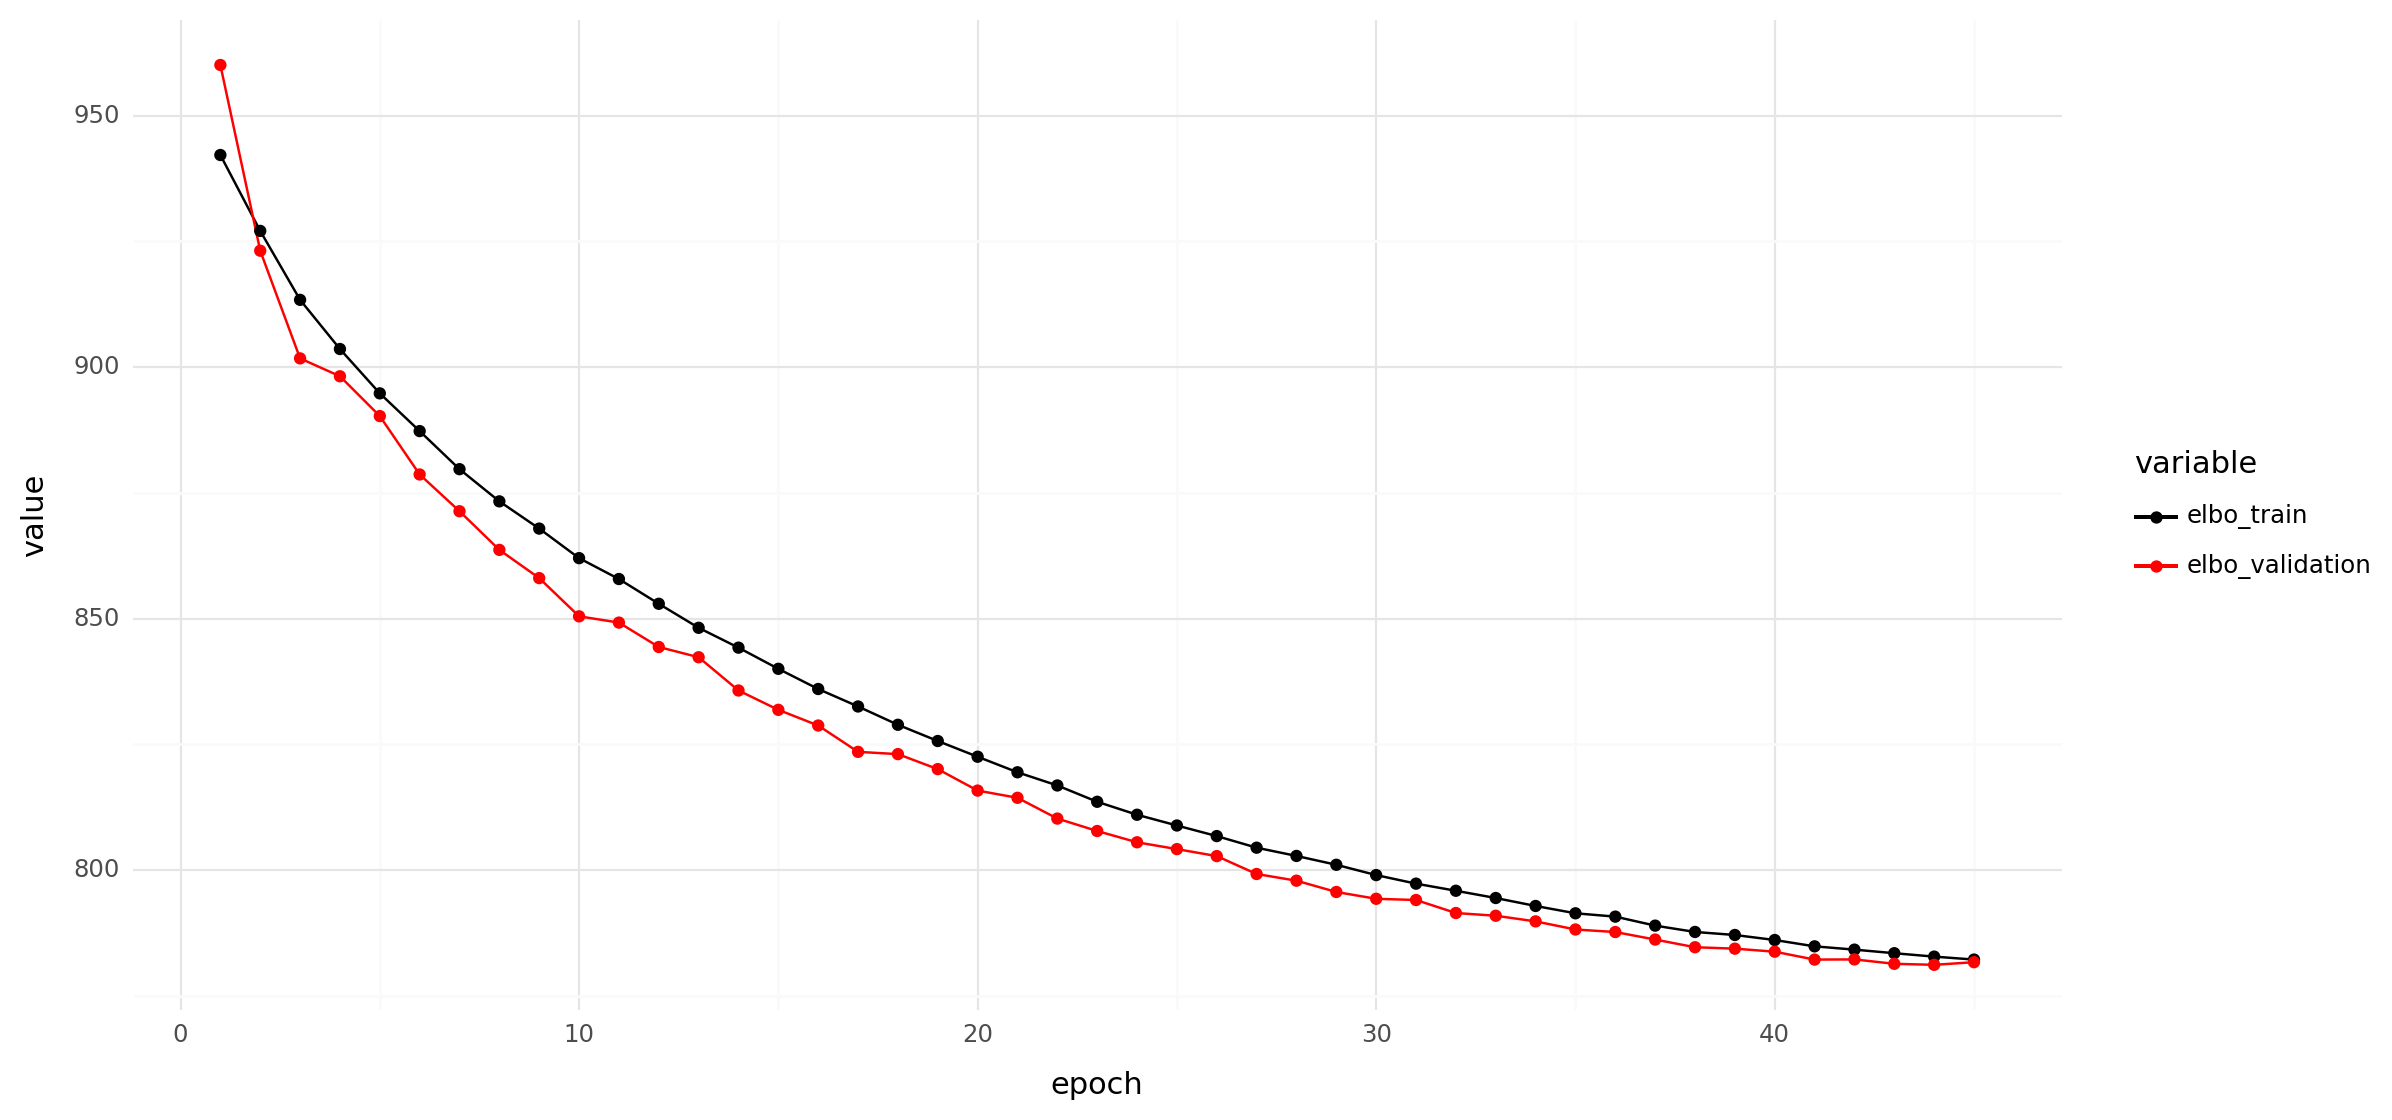

In [459]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [460]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [461]:
scanvi_model.train(11, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 11 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 11/11: 100%|██████████| 11/11 [00:28<00:00,  2.57s/it, v_num=1, train_loss_step=828, train_loss_epoch=769]

`Trainer.fit` stopped: `max_epochs=11` reached.


Epoch 11/11: 100%|██████████| 11/11 [00:28<00:00,  2.61s/it, v_num=1, train_loss_step=828, train_loss_epoch=769]


### Evaluate model performance a la Svensson

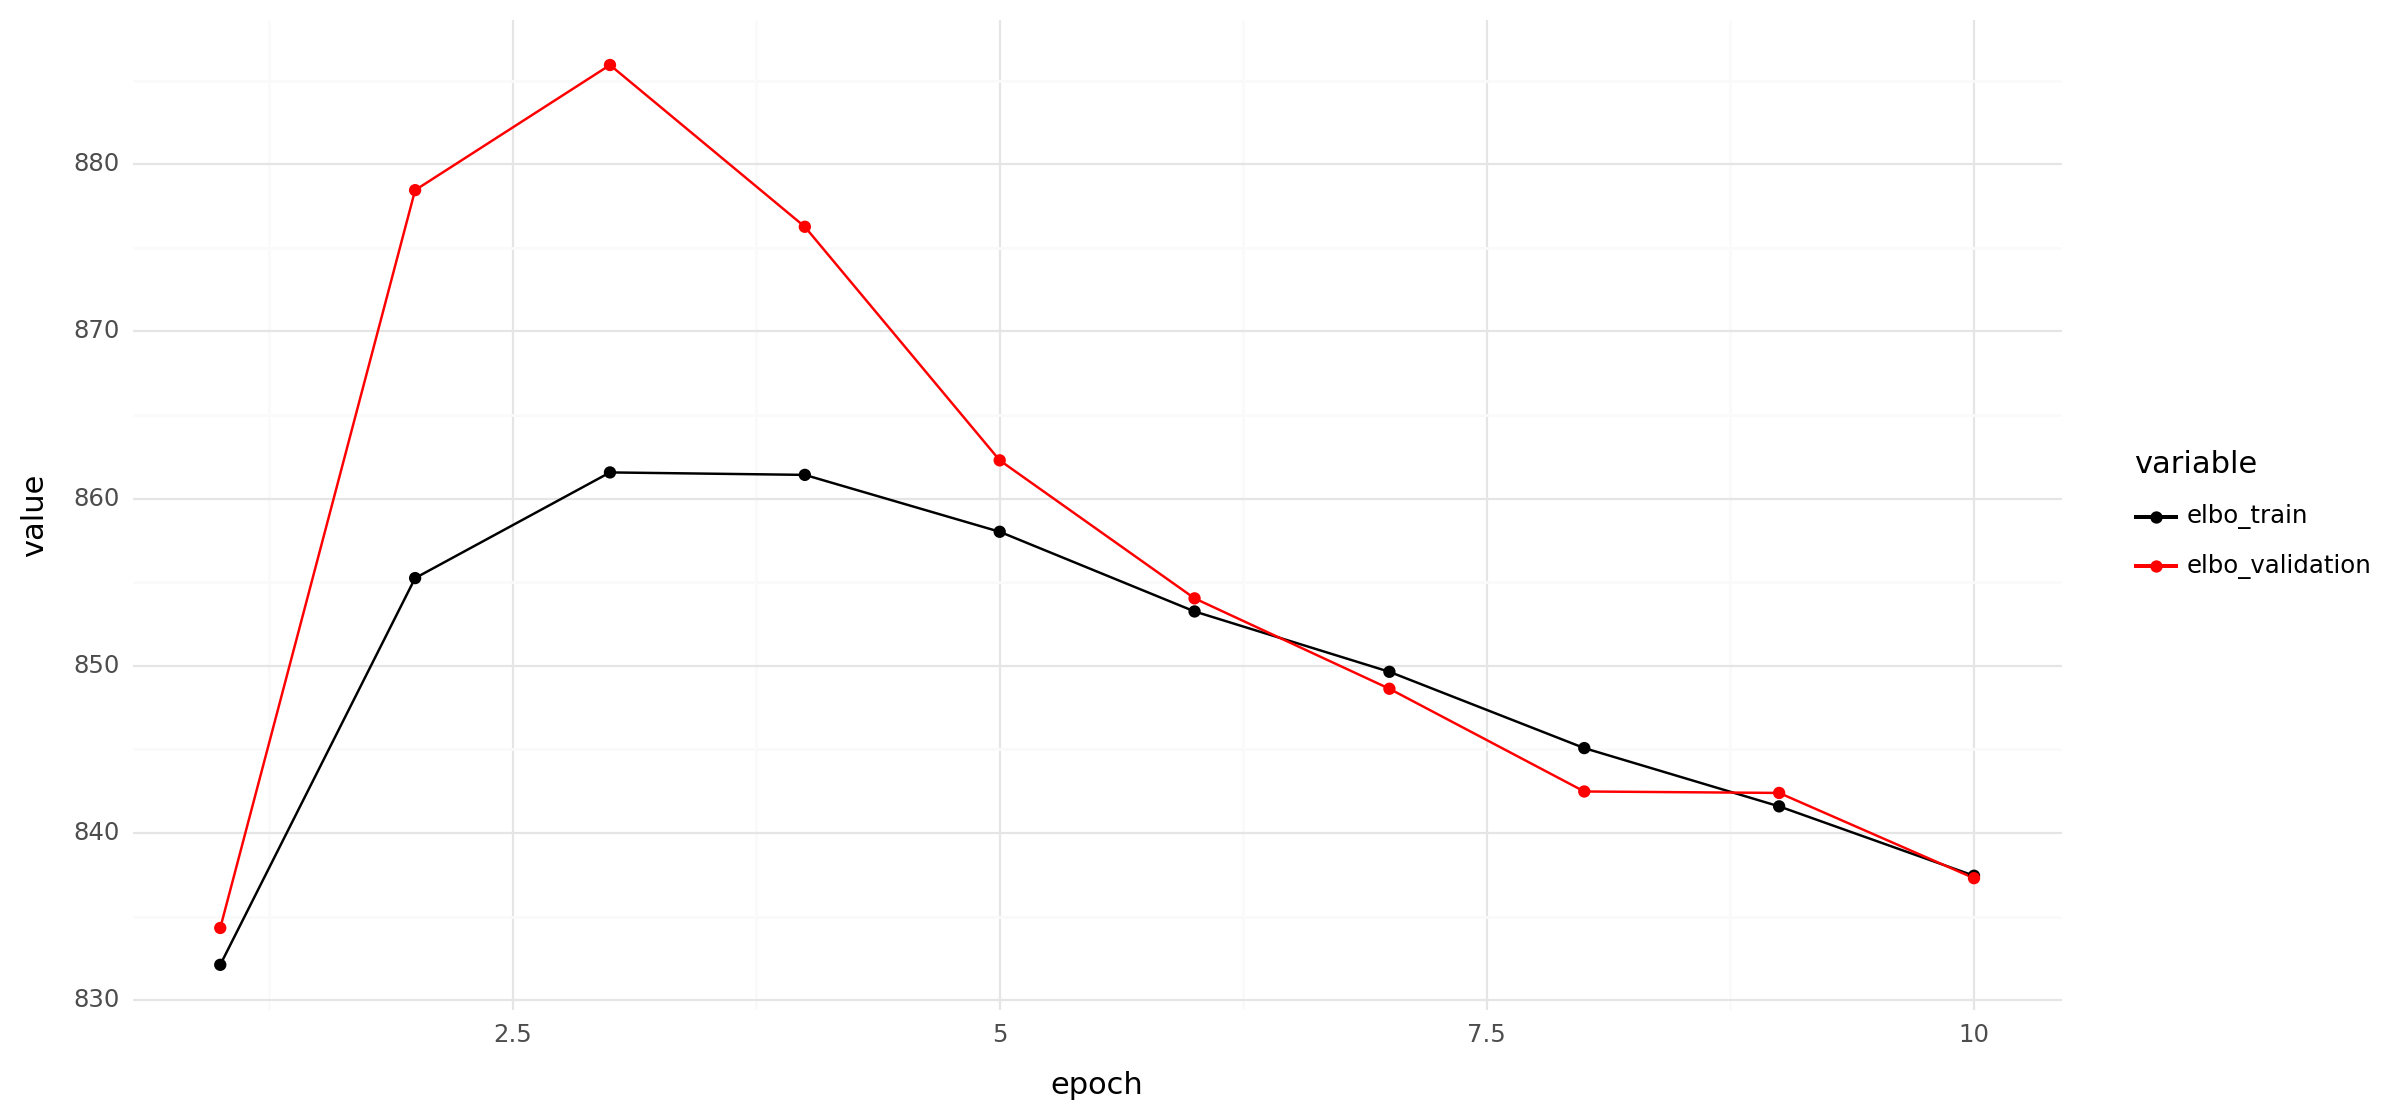

In [462]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [463]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [464]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [465]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


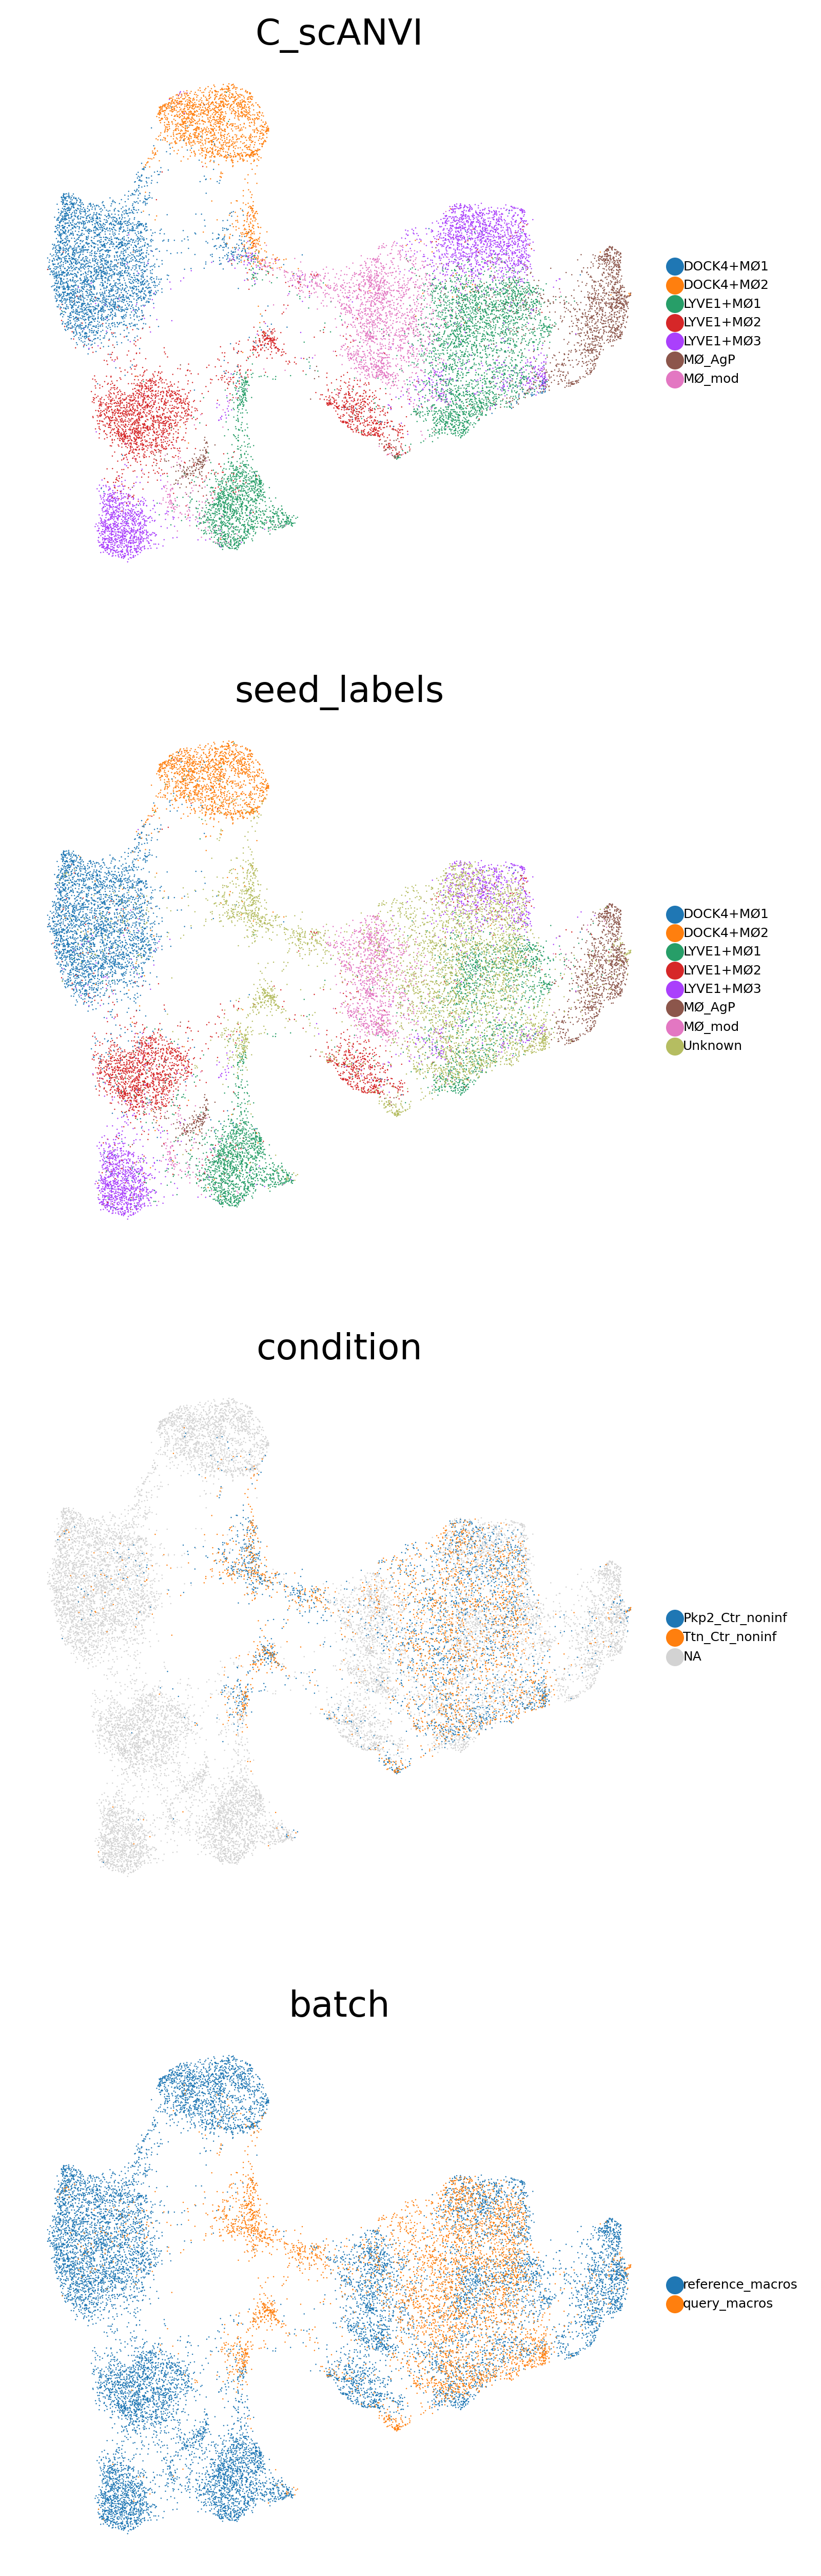

In [466]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch'], size = 1, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [467]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 19167 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_macros', 'feature_types-query_macros', 'mt-query_macros', 'ribo-query_macros', 'n_cells_by_counts-A1-query_macros', 'mean_counts-A1-query_macros', 'pct_dropout_by_counts-A1-query_macros', 'total_counts-A1-query_macros', 'n_cells_by_counts-A2-query_macros', 'mean_counts-A2-query_macros', 'pct_dropout_by_counts-A2-query_macros', 'total_counts-A2-query_macros', 'n_cells_by_

In [468]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query_macros'])]
adata_export

View of AnnData object with n_obs × n_vars = 4648 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_macros', 'feature_types-query_macros', 'mt-query_macros', 'ribo-query_macros', 'n_cells_by_counts-A1-query_macros', 'mean_counts-A1-query_macros', 'pct_dropout_by_counts-A1-query_macros', 'total_counts-A1-query_macros', 'n_cells_by_counts-A2-query_macros', 'mean_counts-A2-query_macros', 'pct_dropout_by_counts-A2-query_macros', 'total_counts-A2-query_macros', 'n_ce

### Add new gene symbols

In [469]:
query_export = anndata.AnnData(X = query_macros.X, var = query_macros.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 4648 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_cou

### Revert gene symbols

In [470]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [471]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
LYVE1+MØ1    1712
LYVE1+MØ3    1050
MØ_mod        709
LYVE1+MØ2     329
DOCK4+MØ2     294
MØ_AgP        280
DOCK4+MØ1     274
Name: count, dtype: int64

In [472]:
query_export

AnnData object with n_obs × n_vars = 4648 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_cou

In [473]:
X_is_raw(query_export)

True

In [474]:
del(query_export.obs["COVID_status"])
del(query_export.obs["annotation_broad"])
del(query_export.obs["annotation_detailed"])
del(query_export.obs['age_group'])
del(query_export.obs['cell_states'])
del(query_export.obs['gender'])
del(query_export.obs['NRP'])
del(query_export.obs['region'])
del(query_export.obs['scNym'])
del(query_export.obs['scNym_confidence'])

In [475]:
query_export.obs

,n_counts,n_genes,donor,sample,cell_source,seed_annotation_general,seed_labels,condition,genotype,infection,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACGCTGTTGTGTTG-1-A1-query-query_macros,750.0,365,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query_macros,14,7,LYVE1+MØ2
AAAGTCCAGGGACACT-1-A1-query-query_macros,14174.0,3788,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query_macros,15,7,LYVE1+MØ1
AAAGTCCCAGTAGGAC-1-A1-query-query_macros,12498.0,3493,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,9.809570,0.016323,0.040006,0.0,-0.142503,-0.357287,query_macros,15,7,LYVE1+MØ1
AAAGTCCTCTACAGGT-1-A1-query-query_macros,9243.0,3064,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,12.236287,0.019582,0.000000,0.0,-0.141045,-0.778679,query_macros,15,7,LYVE1+MØ3
AAATGGACATTACGGT-1-A1-query-query_macros,10307.0,2983,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,...,9.459591,0.025323,0.000000,0.0,-0.243020,-0.563718,query_macros,15,7,LYVE1+MØ3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query-query_macros,18844.0,4219,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query_macros,19,7,LYVE1+MØ1
TTTGGTTTCCTGTACC-1-B2-query-query_macros,11805.0,3321,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query_macros,19,7,LYVE1+MØ1
TTTGTTGCAAGCTCTA-1-B2-query-query_macros,3733.0,1849,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query_macros,18,7,DOCK4+MØ1
TTTGTTGTCCCAGGAC-1-B2-query-query_macros,6388.0,2559,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query_macros,19,7,MØ_mod


In [476]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Macrophages_from_Ctrls_with_scANVI_cellstates_from_healthy_reference_ac240223.raw.h5ad')